# Standard imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
from scipy.integrate import odeint

# Custom imports that are either local or pulled from github

In [4]:
import sys
import requests
import importlib

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # Import functions directly from github
    # Important: note that we use raw.githubusercontent.com, not github.com

    try: # to find the file locally
        if directory is not None:
            if directory not in sys.path:
                sys.path.append(directory)

        package = importlib.import_module(package_name)
        if function_name is not None:
            function = getattr(package, function_name)
            return function
        else:
            return package

    except: # get the file from github
        if giturl is None:
            giturl = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/' + str(package_name) + '.py'

        r = requests.get(giturl)
        print('Fetching from: ')
        print(r)

        # Store the file to the colab working directory
        with open(package_name+'.py', 'w') as f:
            f.write(r.text)
        f.close()

        # import the function we want from that file
        package = importlib.import_module(package_name)
        if function_name is not None:
            function = package.get_attr(function_name)
            return function
        else:
            return package

plot_tme = import_local_or_github('plot_utility', 'plot_tme', directory='../Utility')

# Imports related to model predictive control and pybounds

In [5]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    !pip install pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 9.1 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# Simple rotating agent dynamics

$
\mathbf{\dot{x}} =
\frac{d}{dt}
\begin{bmatrix}
\bbox[yellow]{\theta} \\[0.3em]
\bbox[yellow]{\dot{\theta}} \\[0.3em]
\bbox[yellow]{\psi_1} \\[0.3em]
\bbox[yellow]{\psi_2} \\[0.3em]
\bbox[yellow]{\psi_3} \\[0.3em]
\bbox[yellow]{\gamma} \\[0.3em]
\bbox[yellow]{\rho} \\[0.3em]
\bbox[pink]{k_1} \\[0.3em]
\bbox[pink]{k_2}
\end{bmatrix}
=
\overset{f_0}{\begin{bmatrix}
\bbox[yellow]{\dot{\theta}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}}
+
\overset{f_1}{\begin{bmatrix}
0 \\[0.3em]
\bbox[pink]{k_1}/\bbox[lightblue]{I_{yy}} \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0 \\[0.3em]
0
\end{bmatrix}} \bbox[lightgreen]{u_1}
$

# Set some constant parameters

In [6]:

Iyy = 0.02 # moment of inertia (e.g. 1/12*m*L**2 for a solid rod, as an approximation)


# Define dynamics function



In [16]:
def f(x_vec, u_vec, Iyy=Iyy):
    """
    Continuous time dynamics function for the system shown in the equation.

    Parameters:
    x_vec : array-like, shape (9,)
        State vector [θ, θ̇, psi_1, psi_2, psi_3, gamma, rho, k_1, k_2]
    u_vec : array-like, shape (1,) (for now, could have more elements later)
        Control vector [u_1]
    Iyy : float
        Moment of inertia of the rotating agent

    Returns:
    x_dot : numpy array, shape (9,)
        Time derivative of state vector
    """

    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    psi_1 = x_vec[2]
    psi_2 = x_vec[3]
    psi_3 = x_vec[4]
    gamma = x_vec[5]
    rho = x_vec[6]
    k_1 = x_vec[7]
    k_2 = x_vec[8]

    # Extract control inputs
    u_1 = u_vec[0]


    # f0 component: drift dynamics (no controls)
    f0_contribution = np.array([ theta_dot,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0,
                                 0])

    # f1 component: multiplied by control j1
    f1_contribution = u_1 * np.array([0,
                                     k_1/Iyy,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0,
                                     0])


    # combined dynamics
    x_dot_vec = f0_contribution + f1_contribution

    return x_dot_vec

# Make sure dynamics make sense using odeint

Use odeint to perform a simple ODE solver using a simple controller to verify that the dynamics appear to be correct.  

In [17]:
def f_ode(x_vec, tsim, u_func, f):
    '''
    Wrap dynamics function so it can be used with odeint.

    Parameters:
    x_vec : array-like, shape (9,)
        State vector
    tsim : float
        Current time step
    u_func: function
        Control function
    f: function
        Continuous time dynamics function

    Returns:
    x_dot_vec : numpy array, shape (9,)
        Time derivative of state vector
    '''
    u_vec = u_func(x_vec, tsim)
    x_dot_vec = f(x_vec, u_vec)
    return x_dot_vec

In [18]:
def u_func(x_vec, tsim, Iyy=Iyy):
    '''
    Simple controller that aims to move the drone up, and make the angle oscillate.
    '''
    theta = x_vec[0]
    theta_des = np.sin(tsim)
    err = theta_des - theta
    ctrl = 10*err
    return [ctrl]

In [19]:
# sim time
dt = 0.01
tsim = np.arange(0, 8.0, step=dt)

Maybe I have to define the states as the measured distance from the agent to the thing? Because defining them in coordinates is not going to work...

In [20]:
# calculate distance from initial condition coordinates
psi_1, psi_2, psi_3 = (3,3), (-4,-4), (5,-4)
# rise over run
distance_1 = (psi_1[0]**2 + psi_1[1]**2)**0.5
distance_2 = (psi_2[0]**2 + psi_2[1]**2)**0.5
distance_3 = (psi_3[0]**2 + psi_3[1]**2)**0.5

In [21]:
print(distance_1, distance_2, distance_3)

4.242640687119285 5.656854249492381 6.4031242374328485


In [22]:
# initial condition
x0 = ([0, 0, distance_1, distance_2, distance_3, 135, 90, 1, 1])

In [23]:
# run odeint
result = odeint(f_ode, x0, tsim, args=(u_func, f) )

In [25]:
result

array([[0.00000000e+00, 0.00000000e+00, 4.24264069e+00, ...,
        9.00000000e+01, 1.00000000e+00, 1.00000000e+00],
       [8.31339712e-05, 2.48957044e-02, 4.24264069e+00, ...,
        9.00000000e+01, 1.00000000e+00, 1.00000000e+00],
       [6.60026330e-04, 9.83409601e-02, 4.24264069e+00, ...,
        9.00000000e+01, 1.00000000e+00, 1.00000000e+00],
       ...,
       [9.61422698e-01, 5.40635020e-01, 4.24264069e+00, ...,
        9.00000000e+01, 1.00000000e+00, 1.00000000e+00],
       [9.67567337e-01, 6.82160471e-01, 4.24264069e+00, ...,
        9.00000000e+01, 1.00000000e+00, 1.00000000e+00],
       [9.74931608e-01, 7.83461695e-01, 4.24264069e+00, ...,
        9.00000000e+01, 1.00000000e+00, 1.00000000e+00]])

### Plot some results

Based on the control function and dynamics, does this make sense?

Text(0, 0.5, 'z pos')

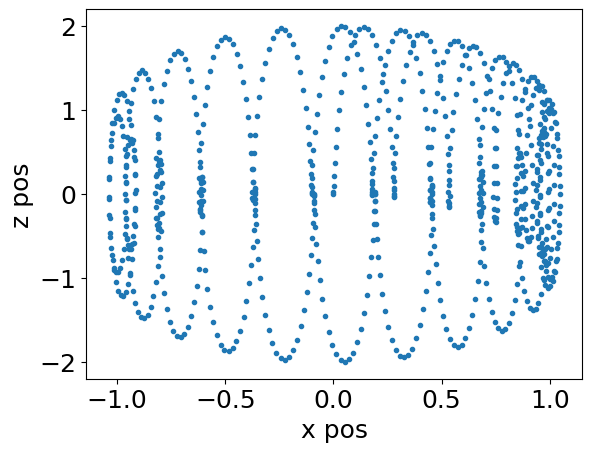

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(result[:,0], result[:,1], '.')
ax.set_xlabel('x pos')
ax.set_ylabel('z pos')

Text(0, 0.5, 'theta')

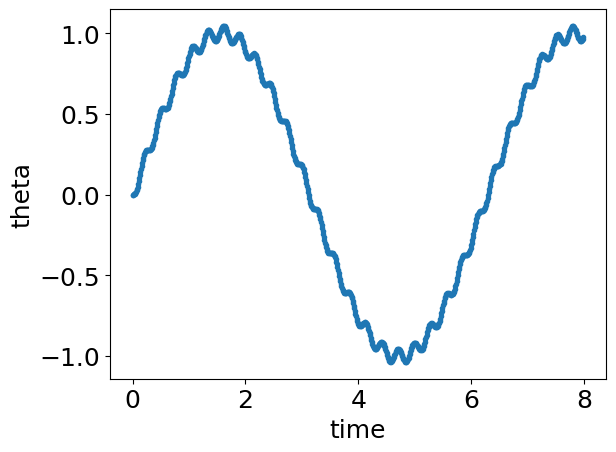

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(tsim, result[:,0], '.')
ax.set_xlabel('time')
ax.set_ylabel('theta')

# Planar drone measurements

Define a measurement function. In this case we consider $\mathbf{y}$ consisting of a downward facing camera that records ventral optic flow, and a measurement of the tilt of the planar drone.

$
\mathbf{y} =
\begin{bmatrix}
\bbox[yellow]{\dot{x}}/\bbox[yellow]{z} \\[0.3em]
\bbox[yellow]{\theta}
\end{bmatrix}
$

In [ ]:
def h(x_vec, u_vec):
    # Extract state variables
    theta = x_vec[0]
    theta_dot = x_vec[1]
    x = x_vec[2]
    x_dot = x_vec[3]
    z = x_vec[4]
    z_dot = x_vec[5]
    k = x_vec[6]

    # Extract control inputs
    j1 = u_vec[0]
    j2 = u_vec[1]

    # Measurements
    y_vec = [x_dot/z, theta]

    # Return measurement
    return y_vec

# Simulate with pybounds / MPC

In [ ]:
import pybounds

In [ ]:
state_names = ['theta', 'theta_dot', 'x', 'x_dot', 'z', 'z_dot', 'k']
input_names = ['j1', 'j2']
measurement_names = ['optic_flow', 'theta']

In [ ]:
dt = 0.1  # [s]

In [ ]:
simulator = pybounds.Simulator(f, h, dt=dt, state_names=state_names,
                               input_names=input_names, measurement_names=measurement_names, mpc_horizon=10)


In [ ]:
# First define the set-point(s) to follow
tsim = np.arange(0, 8.0, step=dt)
NA = np.zeros_like(tsim)
setpoint = {'theta': NA,
            'theta_dot': NA,
            'x': 1.0*np.cos(2*np.pi*tsim*0.3),  # ground speed changes as a sinusoid
            'x_dot': NA,
            'z': 0.3*np.sin(2*np.pi*tsim*0.2)+0.5, # altitude also oscillates
            'z_dot': NA,
            'k': np.ones_like(tsim),
           }

In [ ]:
# Update the simulator set-point
simulator.update_dict(setpoint, name='setpoint')

In [ ]:
# Define MPC cost function: penalize the squared error between the setpoint for g and the true g
cost_x = (simulator.model.x['x'] - simulator.model.tvp['x_set']) ** 2
cost_z = (simulator.model.x['z'] - simulator.model.tvp['z_set']) ** 2
cost_k = (simulator.model.x['k'] - simulator.model.tvp['k_set']) ** 2
cost = cost_x + cost_z #+ cost_k

In [ ]:
# Set cost function
simulator.mpc.set_objective(mterm=cost, lterm=cost)  # objective function

# Set input penalty: make this small for accurate state tracking
simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)

In [ ]:
simulator.mpc.bounds['lower', '_x', 'theta'] = -np.pi/4
simulator.mpc.bounds['upper', '_x', 'theta'] = np.pi/4
simulator.mpc.bounds['lower', '_x', 'z'] = 0.0

simulator.mpc.bounds['lower', '_u', 'j2'] = 0.0

In [ ]:
# Run simulation using MPC
t_sim, x_sim, u_sim, y_sim = simulator.simulate(x0=None, u=None, mpc=True, return_full_output=True)

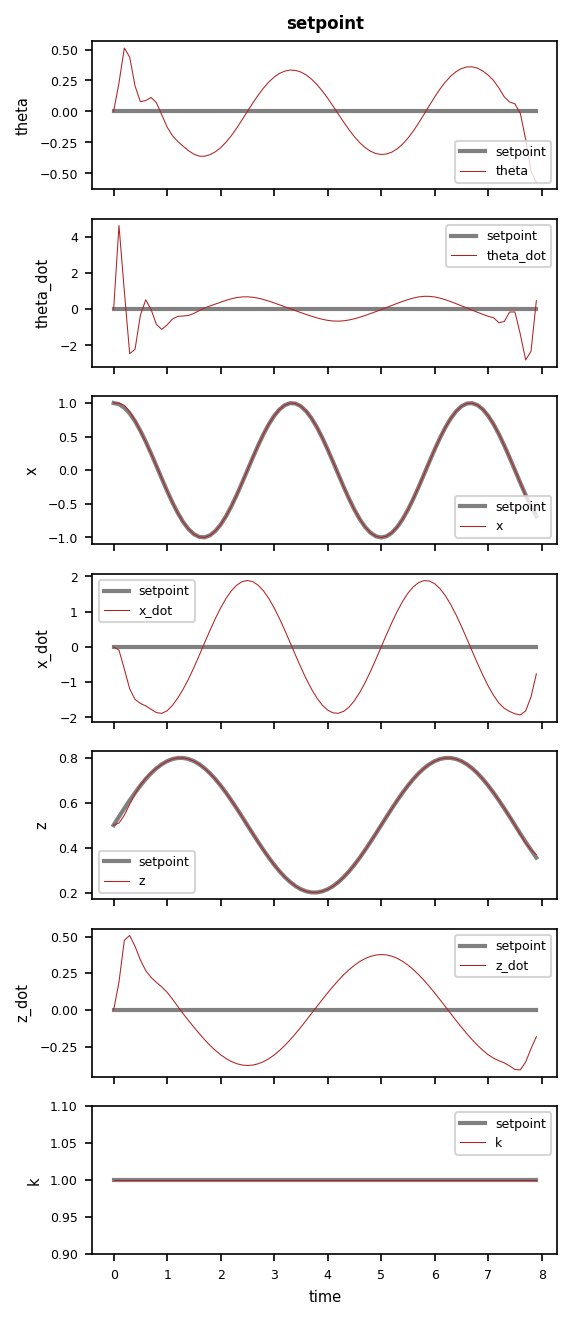

In [ ]:
simulator.plot('setpoint')

# Save the trajectory

This makes is easy to load in a future notebook, for example `B_planar_drone_animation.ipynb`

We will use pandas dataframes and hdf files throughout the course. This serves as a brief introduction.

In [ ]:
# turn all the sim outputs into pandas dataframes
df_x = pandas.DataFrame(x_sim) # x_sim is a dict
df_u = pandas.DataFrame(u_sim) # u_sim is a dict
df_y = pandas.DataFrame(y_sim) # y_sim is a dict
df_t = pandas.DataFrame({'t': t_sim}) # t_sim is a 1d array, make it a dict

# keep states and measurements separate since they can have conflicting names
df_states = pandas.concat([df_t, df_x, df_u], axis=1)
df_measurements = pandas.concat([df_t, df_y], axis=1)

In [ ]:
df_states.to_hdf('planar_drone_sim_states.hdf', 'states')
df_measurements.to_hdf('planar_drone_sim_measurements.hdf', 'measurements')

### look at the dataframe format

In [ ]:
df_states

,t,theta,theta_dot,x,x_dot,z,z_dot,k,j1,j2
0,0.0,0.000000,0.000000,1.000000,0.000000,0.500000,0.000000,1.0,1.848860,11.776317
1,0.1,0.231107,4.622149,0.997736,-0.090374,0.509727,0.190357,1.0,-1.450777,13.798740
2,0.2,0.511975,0.995208,0.964789,-0.628196,0.544222,0.475047,1.0,-1.379203,11.581533
3,0.3,0.439096,-2.452800,0.873379,-1.187611,0.593028,0.507733,1.0,0.096904,9.576972
4,0.4,0.205929,-2.210539,0.737804,-1.488634,0.639508,0.433607,1.0,0.750186,8.961957
...,...,...,...,...,...,...,...,...,...,...
75,7.5,0.061083,-0.150447,0.002942,-1.896770,0.499276,-0.404995,1.0,-0.492655,9.792643
76,7.6,-0.015544,-1.382085,-0.188977,-1.929105,0.458633,-0.407515,1.0,-0.568378,10.424573
77,7.7,-0.224800,-2.803030,-0.378067,-1.816612,0.420758,-0.354071,1.0,0.190491,11.473235
78,7.8,-0.481291,-2.326803,-0.542030,-1.416741,0.390755,-0.263041,1.0,1.120153,12.477465


# Exercises

1. Update the dynamics model to include air drag ($Drag = C*vel^2$, C is a combined drag coefficient, traditionally $C=1/2 \rho C_d A$). Does this make it "easier" or "harder" to control the drone?
2. What is the fastest you can make the drone oscillate in the x dimension?
3. What happens if you change the `rterm` in `simulator.mpc.set_rterm(j1=1e-4, j2=1e-4)`?

# Lessons learned and next steps

### Lessons learned

1. How to simulate a nonlinear dynamical system with python and odeint
2. How to use model predictive control to drive a dynamical systems model along a desired trajectory
3. How to format data as a pandas dataframe, and save data to disk

### Next steps

1. Loading saved data
2. Making an animation

### Long term next steps

1. Use this model and trajectory to analyze observability and write a Kalman filter to estimate states given limited measurements.